In [1]:
from data_loader import *
from segment_support import *
from models import Segment
from data_generator import CustomGenerator
import scipy
import numpy as np
import os
from sklearn.metrics import roc_auc_score, f1_score

X_filenames = ['data/linear_aligned_middle_patch/merged/merged_X_%d.pkl' % i for i in range(37)]
y_filenames = ['data/linear_aligned_middle_patch/merged/merged_y_%d.pkl' % i for i in range(37)]
w_filenames = ['data/linear_aligned_middle_patch/merged/merged_w_%d.pkl' % i for i in range(37)]
name_file = 'data/linear_aligned_middle_patch/merged/merged_names_perfed.pkl'

perfed_names = pickle.load(open(name_file, 'rb'))
train_inds = np.array([i for i, n in perfed_names.items() if not n.split('/')[2].startswith('ex7')])
valid_inds = np.array([i for i, n in perfed_names.items() if n.split('/')[2].startswith('ex7')])

train_gen = CustomGenerator(X_filenames, y_filenames, w_filenames, name_file, batch_size=8, include_day=False, selected_inds=train_inds)
valid_gen = CustomGenerator(X_filenames, y_filenames, w_filenames, name_file, batch_size=8, include_day=False, selected_inds=valid_inds)

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
model = Segment(input_shape=(288, 384, 1))

Tensor("loss/model_2_loss/weighted_binary_cross_entropy/categorical_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


In [3]:
model.load('./baseline2.model')

In [ ]:
def get_ex_day(name):
    n = name.split('/')[3]
    n = n.replace('-', ' ').replace('_', ' ')
    ds_sep = n.split()
    day = None
    for d in ds_sep:
        if d.startswith('D'):
            day = d
    if day is None:
        day = 'Dunknown'
    return (name.split('/')[2], day)

In [ ]:
""" Train Data """
original_dats = pickle.load(open('data/%s_%s.pkl' % get_ex_day(name), 'rb'))
ks = [k for k in list(original_dats.keys()) if get_name(k[0])[1] == '5']
np.random.shuffle(ks)

In [ ]:
for ct, k in enumerate(ks[:10]):
    name = k[0]
    if get_name(name)[1] != '5':
        continue
    for ind, n in perfed_names.items():
        if n == name:
            break
    i = np.where(train_gen.selected_inds == ind)[0].item()
    
    plt.clf()
    plt.imshow(original_dats[k][0])
    plt.savefig('/home/zqwu/Dropbox/fig_temp/sample_%d_0.png' % ct, dpi=160)
    plt.clf()
    plt.imshow(original_dats[k][1])
    plt.savefig('/home/zqwu/Dropbox/fig_temp/sample_%d_1.png' % ct, dpi=160)
    plt.clf()
    _, y, w = train_gen.load_ind(ind)
    y = y*2
    y[np.where(w==0)] += 1
    plt.imshow(y, vmin=0, vmax=2)
    plt.savefig('/home/zqwu/Dropbox/fig_temp/sample_%d_2.png' % ct, dpi=160)
    plt.clf()
    plt.imshow(train_y_preds[i, :, :, 1], vmin=0, vmax=1)
    plt.savefig('/home/zqwu/Dropbox/fig_temp/sample_%d_3.png' % ct, dpi=160)

In [4]:
""" Test Data """
valid_y_preds = model.predict(valid_gen)

In [5]:
original_dats = pickle.load(open('data/ex7_D17.pkl', 'rb'))
ks = [k for k in list(original_dats.keys()) if get_name(k[0])[1] == '5']
np.random.shuffle(ks)

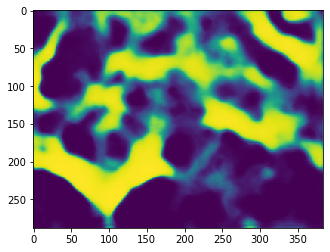

In [9]:
for ct, k in enumerate(ks):
    name = k[0]
    if get_name(name)[1] != '5':
        continue
    for ind, n in perfed_names.items():
        if n == name:
            break
    i = np.where(valid_gen.selected_inds == ind)[0].item()
    
    plt.clf()
    plt.imshow(original_dats[k][0])
    plt.savefig('/home/zqwu/Dropbox/fig_temp/sample_%d_0.png' % ct, dpi=160)
#     plt.show()
    plt.clf()
    plt.imshow(original_dats[k][1])
    plt.savefig('/home/zqwu/Dropbox/fig_temp/sample_%d_1.png' % ct, dpi=160)
#     plt.show()
    plt.clf()
    
    _, y, w, n = valid_gen.load_ind(ind)
    assert n == name
    y = y*2
    y[np.where(w==0)] += 1
    plt.imshow(y, vmin=0, vmax=2)
    plt.savefig('/home/zqwu/Dropbox/fig_temp/sample_%d_2.png' % ct, dpi=160)
#     plt.show()
    plt.clf()
    plt.imshow(valid_y_preds[i, :, :, 1], vmin=0, vmax=1)
    plt.savefig('/home/zqwu/Dropbox/fig_temp/sample_%d_3.png' % ct, dpi=160)
#     plt.show()

In [ ]:
y_trues = []
for batch in CustomGenerator(X_filenames, y_filenames, w_filenames, 3698, batch_size=1, selected_inds=train_inds):
    y_true = batch[1][:, :, :, :-1]
    w = batch[1][:, :, :, -1]
    y_trues.append(y_true[np.nonzero(w)])
ratio = [y_[:, 1].sum()/y_.shape[0] for y_ in y_trues]
print((np.array(ratio) > 0).sum()/len(ratio))
plt.clf()
plt.hist(ratio, bins=np.arange(0.005, 0.5, 0.01))
plt.savefig('/home/zqwu/Dropbox/fig_temp/train_ratio.png', dpi=300)

In [ ]:
y_trues = []
for batch in CustomGenerator(X_filenames, y_filenames, w_filenames, 3698, batch_size=1, selected_inds=valid_inds):
    y_true = batch[1][:, :, :, :-1]
    w = batch[1][:, :, :, -1]
    y_trues.append(y_true[np.nonzero(w)])
ratio = [y_[:, 1].sum()/y_.shape[0] for y_ in y_trues]
print((np.array(ratio) > 0).sum()/len(ratio))
plt.clf()
plt.hist(ratio, bins=np.arange(0.005, 0.5, 0.01))
plt.savefig('/home/zqwu/Dropbox/fig_temp/valid_ratio.png', dpi=300)

In [ ]:
y_preds = []
y_trues = []
ious = []
for batch in CustomGenerator(X_filenames, y_filenames, w_filenames, name_file, include_day=True, batch_size=1, selected_inds=valid_inds):
    y_pred = model.model.predict(batch[0])
    y_pred = scipy.special.softmax(y_pred, -1)
    y_true = batch[1][:, :, :, :-1]
    w = batch[1][:, :, :, -1]
    y_preds.append(y_pred[np.nonzero(w)])
    y_trues.append(y_true[np.nonzero(w)])

    intersection = ((y_preds[-1][:, 1] > 0.5) * y_trues[-1][:, 1]).sum()
    union = (np.sign((y_preds[-1][:, 1] > 0.5) + y_trues[-1][:, 1])).sum()
    ious.append(intersection/union)
    
_y_preds = np.concatenate(y_preds, 0).reshape((-1, 2))
_y_trues = np.concatenate(y_trues, 0).reshape((-1, 2))

In [ ]:
all_intersection = ((_y_preds[:, 1] > 0.5) * _y_trues[:, 1]).sum()
all_union = (np.sign((_y_preds[:, 1] > 0.5) + _y_trues[:, 1])).sum()
print(all_intersection/all_union)
print(roc_auc_score(_y_trues, _y_preds))
print(f1_score(_y_trues[:, 1], _y_preds[:, 1] > 0.5))

In [33]:
y_trues = []
for batch in valid_gen:
    y_trues.append(batch[1])

In [34]:
y_trues = np.concatenate(y_trues, 0)
y_trues.shape

(339, 288, 384, 3)

In [36]:
for thr in np.arange(0.1, 0.9, 0.1):
    error_counts1 = 0
    error_counts2 = 0
    for i in range(339):
        pos_counts = y_trues[i, :, :, 1].sum()
        invalid_pixels = (1 - y_trues[i, :, :, 2]).sum()
        pos_counts_pred = (valid_y_preds[i, :, :, 1]>thr).sum()
        if invalid_pixels==0 and pos_counts == 0 and pos_counts_pred > (288*384*0.01):
          error_counts1 += 1
        if pos_counts > 288*384*0.01 and pos_counts_pred < 288*384*0.01:
          error_counts2 += 1
    print(error_counts1)
    print(error_counts2)

44
1
38
5
34
7
32
8
28
13
22
20
20
22
16
34


In [38]:
13/339

0.038348082595870206

In [27]:
error_counts1

56